In [29]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [30]:
from pyspark import SparkContext, SparkConf
from datetime import datetime
from timeit import timeit


In [1]:
tweetDataFrame = sqlContext.read.json('group_assignment/tweets/tweets_extended.json')
tweetDataFrame.printSchema()

root
 |-- created_at: long (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |-- sizes: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = tr

(1, 12)

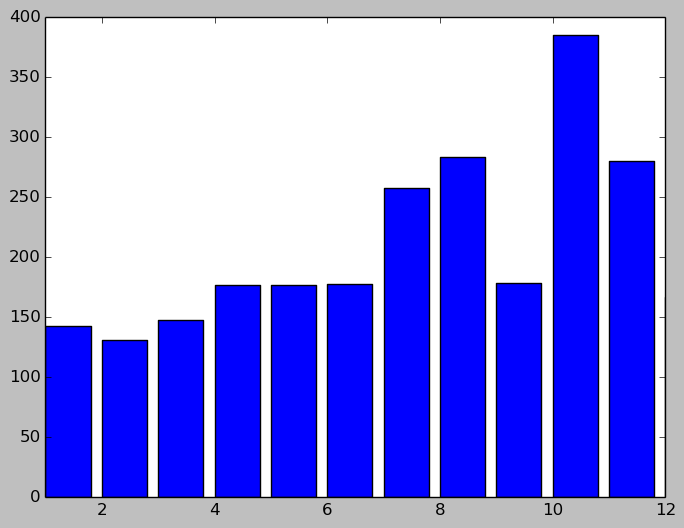

In [2]:
"""
group by date month tweets
"""
import datetime

dates = tweetDataFrame.select('created_at').map(lambda x: datetime.datetime.fromtimestamp(x[0] / 1e3))
dates = dates.groupBy(lambda x: x.month).sortByKey()
dates = dates.map(lambda x : (x[0], len(list(x[1])))).collect()
x,y = zip(*dates)

import matplotlib.pyplot as plt
plt.figure()
plt.bar(x,y)
plt.xlim(1,12)






In [49]:
"""
EXTRACTING THE MMA TWEETS
"""
import re

def filter_mma(row):
    """
    filters mma row
    """
    #variable contains list of meaningful MMA expressions, after cleaning expressions such as
    #u'TOMMARRS', u'DILEMMA', u'SUMMARY', u'MUHAMMAD_WAKAS',u'SUMMARIZING', u'SUMMARIZED' ....
    
    mma_accepted = ['MMA_BLOG', 'SMMMAGAZINE', 'MMA_CRM', 'MMA', 'BIG', 'BIGDATA', 'SASANALYTICS', 'ANALYTICS', 'ANALYSIS', 'RSTATS', 'STATFACT', 'AMSTATNEWS' 'STATISTICIANS', 'STATS', 'STAT', 'STATISTICAL', 'MASTAT', 'DATASCIENCE', 'SCIENTIST'] 
    
    #start matching
    regex_p1 =  r'(\w*%s\w*)' % 'MMA'
    regex_p2 =  r'(\w*%s\w*)' % 'BIG'
    regex_p3 =  r'(\w*%s\w*)' % 'ANALY'
    regex_p4 =  r'(\w*%s\w*)' % 'STAT'
    regex_p5 =  r'(\w*%s\w*)' % 'SCIENTIST'
    regex_p5 =  r'(\w*%s\w*)' % 'DATASCIENCE'
    results = re.findall(regex_p1, row.text.upper()) + re.findall(regex_p2, row.text.upper()) + re.findall(regex_p3, row.text.upper()) + re.findall(regex_p4, row.text.upper())
    #now see if one of the expression is an 'accepted' expression
    results = [r for r in results if r in mma_accepted]
    
    if len(results) > 0:
        return True
    return False
    
    
#mma_tweets = tweetDataFrame.selectExpr('id', 'created_at', 'text', 'entities.hashtags.text').rdd
#mma_tweets = mma_tweets.filter(lambda x: filter_mma(x))#.collect()

mma_tweets = tweetDataFrame.rdd#.selectExpr('id', 'created_at', 'text', 'entities.hashtags.text').rdd
mma_tweets = mma_tweets.filter(lambda x: filter_mma(x))#.collect()

#for t in mma_tweets:
#    print t.text +  '\n'




In [50]:
#mma_tweets.count()
mma_tweets.take(1)

[Row(created_at=1421145736000L, entities=Row(hashtags=[Row(indices=[12, 19], text=u'rstats'), Row(indices=[46, 56], text=u'Analytics')], media=[Row(display_url=u'pic.twitter.com/zWJYW4fyLH', expanded_url=u'http://twitter.com/dirkvandenpoel/status/554951556899299328/photo/1', id=554951534987845632L, id_str=u'554951534987845632', indices=[115, 137], media_url=u'http://pbs.twimg.com/media/B7OVexaCIAArAKZ.jpg', media_url_https=u'https://pbs.twimg.com/media/B7OVexaCIAArAKZ.jpg', sizes=[Row(h=255, resize=u'fit', w=340), Row(h=450, resize=u'fit', w=600), Row(h=768, resize=u'fit', w=1024), Row(h=150, resize=u'crop', w=150), Row(h=768, resize=u'fit', w=1024)], url=u'http://t.co/zWJYW4fyLH')], urls=[], user_mentions=[Row(id=397308843, id_str=u'397308843', indices=[66, 73], name=u'MarketingEngineering', screen_name=u'HIR_ME'), Row(id=221873535, id_str=u'221873535', indices=[78, 86], name=u'Marketing Analytics', screen_name=u'MMA_CRM'), Row(id=491262150, id_str=u'491262150', indices=[90, 103], nam

In [7]:
"""
TOYING WITH RETWEETED STATUS AND DATES
"""
import datetime
from pyspark.sql import Row
import numpy as np
"""
HELPER FUNCTIONS FOR retweets per tweets
"""
def aggregate_retweet_per_tweet(aggregated_dict, twitter_struct):
    if twitter_struct['id'] in aggregated_dict:
        aggregated_dict[twitter_struct['id']] += twitter_struct['retweet_number']
        return aggregated_dict
    
    aggregated_dict[twitter_struct['id']] = twitter_struct['retweet_number']
    return aggregated_dict
    
"""
execute
"""
retweets_per_tweet = tweetDataFrame.selectExpr('id','retweeted_status.id as r_id')
retweets_per_tweet = retweets_per_tweet.map(lambda x: {'id' : x.id, 'retweet_number' : 1 if x.r_id else 0}).collect()
retweets_per_tweet = reduce(aggregate_retweet_per_tweet, retweets_per_tweet,{}) #going for normal python data type
retweets_per_tweet = np.mean([retweets_per_tweet[id] for id in retweets_per_tweet])
print retweets_per_tweet #prints averga


"""
HELPER FUNCTIONS FOR DELTA DAYS
"""
def clean_up_row(row):
    """
    cleans up row and return new row object
    """
    return Row(
        id=row.id,
        created_at=convert_long_date(row.created_at),
        retweeted_at=convert_date_string(row.retweeted_at),
        )

def convert_long_date(long_date):
    return datetime.datetime.fromtimestamp(long_date / 1e3)

def convert_date_string(date_string):
    """
    converts e.g. 2015-01-31 12:30:30 +0000
    """
    if not date_string:
        return None
    return datetime.datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S +0000')

def convert_retweeted_at_to_days_since_original_tweet(row):
    """
    returns new Row(id, created_at, retweeted_at_delta in minutes)
    """
    delta = row.created_at - row.retweeted_at
    delta =( delta.days * 24 * 60) + (delta.seconds/60) #in minutes
    
    return Row(
        id=row.id,
        created_at=row.created_at,
        retweeted_at_delta=delta
        )

def collect_retweeted_days_to_array(row):
    """
    expects Row(id, iterable(Row(created_at, id, retweeted_at_delta_1), ..., Row(created_at, id, retweeted_at_delta_n))
    returns [retweeted_at_delta_1, ..., retweeted_at_delta_n]
    """
    return [days for days in row[0]]

"""
Execute query
"""
test = tweetDataFrame.selectExpr('id','created_at', 'retweeted_status.created_at as retweeted_at')
test = test.map(lambda x:  clean_up_row(x))
test = test.filter(lambda x: True if x.retweeted_at else False) #remove empty rows (no retweet)
test = test.map(lambda x: convert_retweeted_at_to_days_since_original_tweet(x))
test = test.groupBy(lambda x: x.id) #group al retweets 
test = test.collect()




0.461291616526


In [8]:
test = tweetDataFrame.selectExpr('id','text', 'created_at', 'retweeted_status.created_at as retweeted_at', 'user.id', 'entities.hashtags[0].text')
test.take(1)

[Row(id=561242031977398272L, text=u'RT @fotograaf: Light Festival #Ghent #Belgium @Lichtfestivalge #lichtfestival #gent http://t.co/BPSQzwHQKT', created_at=1422645502000L, retweeted_at=u'2015-01-30 19:06:56 +0000', id=60014176, entities.hashtags[0][text]=u'Ghent')]

In [54]:
dates = tweetDataFrame.select('id', 'created_at','entities.hashtags.text')
#type(dates)
dates.take(1)

[Row(id=561242031977398272L, created_at=1422645502000L, text=[u'Ghent', u'Belgium', u'lichtfestival', u'gent'])]

In [60]:
import datetime
from pyspark.sql import Row
import numpy as np
"""
HELPER FUNCTIONS FOR retweets per tweets
"""
def aggregate_retweet_per_tweet(aggregated_dict, twitter_struct):
    if twitter_struct['id'] in aggregated_dict:
        aggregated_dict[twitter_struct['id']] += twitter_struct['retweet_number']
        return aggregated_dict
    
    aggregated_dict[twitter_struct['id']] = twitter_struct['retweet_number']
    return aggregated_dict
    
"""
execute
"""
retweets_per_tweet = tweetDataFrame.selectExpr('id','retweeted_status.id as r_id')
retweets_per_tweet = retweets_per_tweet.map(lambda x: {'id' : x.id, 'retweet_number' : 1 if x.r_id else 0}).collect()
retweets_per_tweet = reduce(aggregate_retweet_per_tweet, retweets_per_tweet,{}) #going for normal python data type
retweets_per_tweet = np.mean([retweets_per_tweet[id] for id in retweets_per_tweet])
print retweets_per_tweet #prints averga


"""
HELPER FUNCTIONS FOR DELTA DAYS
"""
def clean_up_row(row):
    """
    cleans up row and return new row object
    """
    return Row(       
        id=row.id,
        hashtags=row.hashtags,
        hashtags_count = len(row.hashtags),
        tweet=row.text,
        created_at=convert_long_date(row.created_at),
        #retweeted_at=convert_date_string(row.retweeted_at),
        )

def convert_long_date(long_date):
    return datetime.datetime.fromtimestamp(long_date / 1e3)

def convert_date_string(date_string):
    """
    converts e.g. 2015-01-31 12:30:30 +0000
    """
    if not date_string:
        return None
    return datetime.datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S +0000')



"""
Execute query
"""

tweets = tweetDataFrame.selectExpr('id', 'created_at','text','entities.hashtags.text as hashtags')
tweets_clean = tweets.map( lambda x:  clean_up_row(x))
#test = test.flatmap(lambda x: x.hashtags())
tweets_clean.take(1)
#test = test.filter(lambda x: True if x.retweeted_at else False) #remove empty rows (no retweet)
#test = test.map(lambda x: convert_retweeted_at_to_days_since_original_tweet(x))
#test = test.groupBy(lambda x: x.id) #group al retweets 
#test = test.collect()



0.461291616526


[Row(created_at=datetime.datetime(2015, 1, 30, 19, 18, 22), hashtags=[u'Ghent', u'Belgium', u'lichtfestival', u'gent'], hashtags_count=4, id=561242031977398272L, tweet=u'RT @fotograaf: Light Festival #Ghent #Belgium @Lichtfestivalge #lichtfestival #gent http://t.co/BPSQzwHQKT')]